# Loading CIFAR-10

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10

In [2]:
import numpy as np

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape  == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape  == (10000, 1)

y_train = np.squeeze(y_train)
y_test  = np.squeeze(y_test)

data_labels = {
    0 : 'airplane',
    1 : 'automobile',
    2 : 'bird',
    3 : 'cat',
    4 : 'deer',
    5 : 'dog',
    6 : 'frog',
    7 : 'horse',
    8 : 'ship',
    9 : 'truck'
}

170508288/170498071 [==============================] - 4s 0us/step


## Plotting some samples

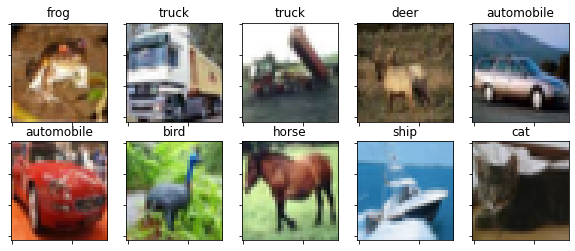

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,5, figsize=(10,4))

counter = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[counter], aspect='auto')
        ax[i,j].set_title(data_labels[y_train[counter]])
        ax[i,j].set_yticklabels([])
        ax[i,j].set_xticklabels([])
        counter += 1

## Counting labels

In [4]:
for i in data_labels.keys():
    print(f'{data_labels[i]} : {len(np.where(y_train==i)[0])}')

airplane : 5000
automobile : 5000
bird : 5000
cat : 5000
deer : 5000
dog : 5000
frog : 5000
horse : 5000
ship : 5000
truck : 5000


## Split validation

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, shuffle=True)

## Visualizations

In [37]:
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score

def plot_history(history):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,5),sharex=True)
    r = np.arange(len(history.history['loss']))+1
    ax[0].plot(r, history.history['loss'],label='Train')
    ax[0].plot(r, history.history['val_loss'],label='Validation')
    ax[0].set_ylabel('Loss Value')
    ax[0].legend()
    ax[0].grid(True)
    ax[1].plot(r, history.history['accuracy'],label='Train')
    ax[1].plot(r, history.history['val_accuracy'],label='Validation')
    ax[1].set_ylabel('Accuracy Value')
    ax[1].set_xlabel('Epoch')
    ax[1].legend()
    ax[1].grid(True)
    #name = f'Model {model_type}_Run {run}_curves.pdf'
    plt.show()
    #fig.savefig(directory/name)
    plt.close(fig)

def confusion(model, x_test, y_test):
    y_pred = np.argmax(model.predict(x_test), axis=1)
    acc = accuracy_score(y_test, y_pred)
    print (f'accuracy = {acc}')
    cm = confusion_matrix(y_test, y_pred)
    cm_norm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    con_mat_df = pd.DataFrame(cm_norm,index = data_labels.values(), columns = data_labels.values())

    fig = plt.figure(figsize=(10, 10))
    sns.heatmap(con_mat_df, annot=True,cmap="YlGnBu")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Test data confusion matrix')
    plt.show()

# MLP

## Data prepration

In [40]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
pixels = 32*32*3

x_tr = np.reshape(x_train, (-1, pixels))
x_tr = scaler.fit_transform(x_tr)
x_va = np.reshape(x_valid, (-1, pixels))
x_va = scaler.transform(x_va)
x_te = np.reshape(x_test , (-1, pixels))
x_te = scaler.transform(x_te)

print(x_tr.shape, x_va.shape, x_te.shape)

(40000, 3072) (10000, 3072) (10000, 3072)


## MLP definition

In [41]:
from tensorflow.keras.layers import Dense, Dropout, Input, Softmax, Activation

def get_mlp(layers, dropout = 0.25, act = tf.nn.relu):
    model = keras.Sequential()
    model.add(Input(shape=(layers[0],)))
    
    depth = len(layers)-1
    for i in range(1, depth+1):
        model.add(Dense(units=layers[i], name=f'dense-{i}'))
        if i != depth:
            model.add(Activation(act, name=f'activation-{i}'))
            if dropout > 0:
                model.add(Dropout(rate=dropout))
        else:
            model.add(Softmax(axis=1, name='softmax'))
    return model

In [45]:
layers = [pixels, 500, 250, 10]
model  = get_mlp(layers, dropout=0.25)

# building the model using a dummy input
dummy = tf.random.normal(x_tr[0:2,:].shape)
_ = model.predict(dummy) 

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense-1 (Dense)             (None, 500)               1536500   
                                                                 
 activation-1 (Activation)   (None, 500)               0         
                                                                 
 dropout_8 (Dropout)         (None, 500)               0         
                                                                 
 dense-2 (Dense)             (None, 250)               125250    
                                                                 
 activation-2 (Activation)   (None, 250)               0         
                                                                 
 dropout_9 (Dropout)         (None, 250)               0         
                                                                 
 dense-3 (Dense)             (None, 10)               

## MLP training

In [46]:
lr = 0.025
bs = 200
ep = 400

er_stop = keras.callbacks.EarlyStopping(
    monitor= 'val_accuracy',patience=40,restore_best_weights=True
)

model.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [47]:
hist = model.fit(
    x_tr, y_train,
    batch_size = bs, epochs = ep,
    validation_data = (x_va,y_valid),
    verbose=2, callbacks = [er_stop]
)

Epoch 1/400
200/200 - 2s - loss: 1.9584 - accuracy: 0.3130 - val_loss: 1.6827 - val_accuracy: 0.4119 - 2s/epoch - 8ms/step
Epoch 2/400
200/200 - 1s - loss: 1.7002 - accuracy: 0.3989 - val_loss: 1.6035 - val_accuracy: 0.4337 - 1s/epoch - 5ms/step
Epoch 3/400
200/200 - 1s - loss: 1.6183 - accuracy: 0.4262 - val_loss: 1.5532 - val_accuracy: 0.4495 - 1s/epoch - 5ms/step
Epoch 4/400
200/200 - 1s - loss: 1.5585 - accuracy: 0.4500 - val_loss: 1.5197 - val_accuracy: 0.4602 - 1s/epoch - 6ms/step
Epoch 5/400
200/200 - 1s - loss: 1.5180 - accuracy: 0.4663 - val_loss: 1.4964 - val_accuracy: 0.4745 - 1s/epoch - 5ms/step
Epoch 6/400
200/200 - 1s - loss: 1.4829 - accuracy: 0.4775 - val_loss: 1.4719 - val_accuracy: 0.4797 - 1s/epoch - 6ms/step
Epoch 7/400
200/200 - 1s - loss: 1.4460 - accuracy: 0.4911 - val_loss: 1.4565 - val_accuracy: 0.4856 - 1s/epoch - 6ms/step
Epoch 8/400
200/200 - 1s - loss: 1.4160 - accuracy: 0.4988 - val_loss: 1.4409 - val_accuracy: 0.4921 - 1s/epoch - 5ms/step
Epoch 9/400
200/

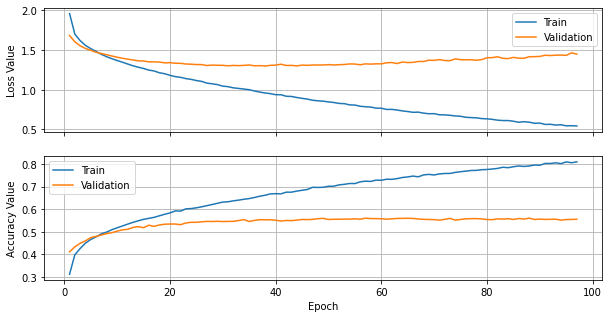

accuracy = 0.554


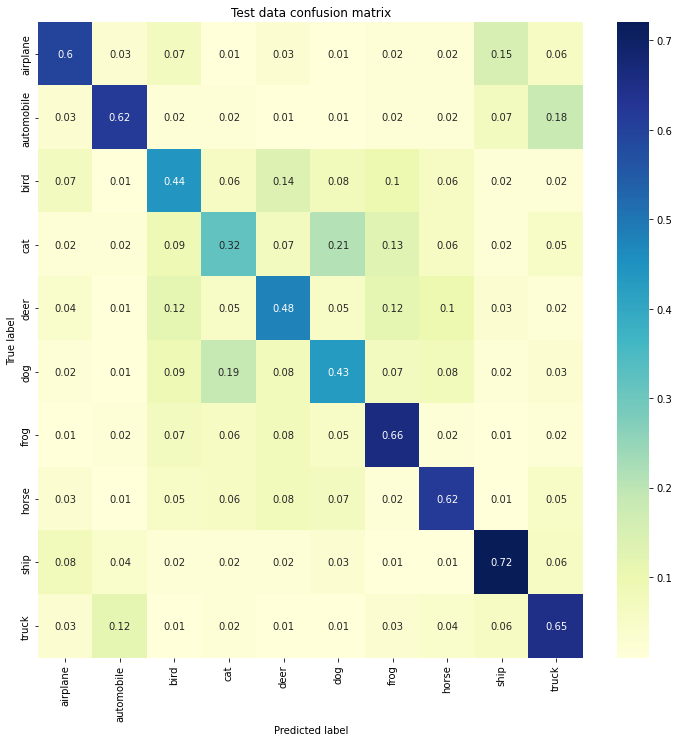

In [48]:
plot_history(hist)
confusion(model, x_te, y_test)

# A. Effect of batch size


## Timing functions

In [49]:
import time

def TicTocGenerator():
    # Generator that returns time differences
    ti = 0           # initial time
    tf = time.time() # final time
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti # returns the time difference

TicToc = TicTocGenerator() # create an instance of the TicTocGen generator

# This will be the main function through which we define both tic() and toc()
def toc(tempBool=True):
    # Prints the time difference yielded by generator instance TicToc
    tempTimeInterval = next(TicToc)
    if tempBool:
        print( "Elapsed time: %f seconds.\n" %tempTimeInterval )

def tic():
    # Records a time in TicToc, marks the beginning of a time interval
    toc(False)

## BS = 64

Epoch 1/400
625/625 - 3s - loss: 1.8281 - accuracy: 0.3564 - val_loss: 1.6024 - val_accuracy: 0.4367 - 3s/epoch - 5ms/step
Epoch 2/400
625/625 - 3s - loss: 1.6062 - accuracy: 0.4326 - val_loss: 1.5276 - val_accuracy: 0.4588 - 3s/epoch - 4ms/step
Epoch 3/400
625/625 - 3s - loss: 1.5232 - accuracy: 0.4641 - val_loss: 1.4856 - val_accuracy: 0.4834 - 3s/epoch - 4ms/step
Epoch 4/400
625/625 - 3s - loss: 1.4630 - accuracy: 0.4843 - val_loss: 1.4517 - val_accuracy: 0.4868 - 3s/epoch - 4ms/step
Epoch 5/400
625/625 - 3s - loss: 1.4178 - accuracy: 0.4981 - val_loss: 1.4364 - val_accuracy: 0.4982 - 3s/epoch - 4ms/step
Epoch 6/400
625/625 - 3s - loss: 1.3767 - accuracy: 0.5127 - val_loss: 1.4148 - val_accuracy: 0.5027 - 3s/epoch - 4ms/step
Epoch 7/400
625/625 - 3s - loss: 1.3464 - accuracy: 0.5236 - val_loss: 1.4015 - val_accuracy: 0.5034 - 3s/epoch - 4ms/step
Epoch 8/400
625/625 - 3s - loss: 1.3132 - accuracy: 0.5344 - val_loss: 1.3797 - val_accuracy: 0.5157 - 3s/epoch - 4ms/step
Epoch 9/400
625/

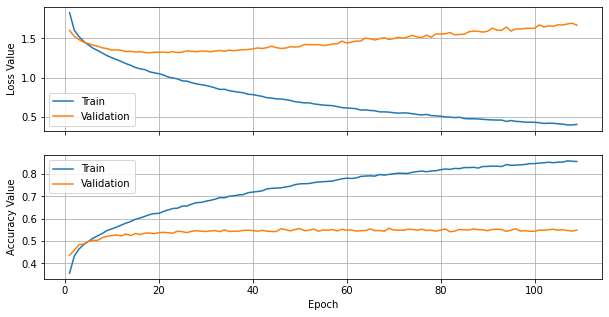

accuracy = 0.5499


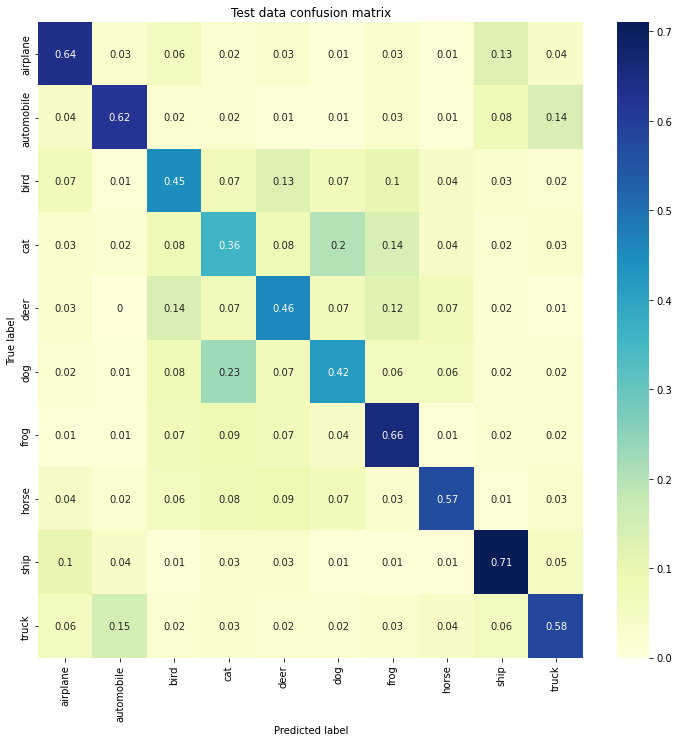

In [50]:
model1  = get_mlp(layers, dropout=0.25)
dummy = tf.random.normal(x_tr[0:2,:].shape)
_ = model1.predict(dummy)

bs = 64

model1.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

tic()
hist1 = model1.fit(
    x_tr, y_train,
    batch_size = bs, epochs = ep,
    validation_data = (x_va,y_valid),
    verbose=2, callbacks = [er_stop]
)
toc()

plot_history(hist1)
confusion(model1, x_te, y_test)

## BS = 32

In [ ]:
model2  = get_mlp(layers, dropout=0.25)
dummy = tf.random.normal(x_tr[0:2,:].shape)
_ = model2.predict(dummy)

bs = 32

model2.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

tic()
hist2 = model2.fit(
    x_tr, y_train,
    batch_size = bs, epochs = ep,
    validation_data = (x_va,y_valid),
    verbose=2, callbacks = [er_stop]
)
toc()

plot_history(hist2)
confusion(model2, x_te, y_test)

## BS = 256

In [ ]:
model3  = get_mlp(layers, dropout=0.25)
dummy = tf.random.normal(x_tr[0:2,:].shape)
_ = model3.predict(dummy)

bs = 256

model3.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

tic()
hist3 = model3.fit(
    x_tr, y_train,
    batch_size = bs, epochs = ep,
    validation_data = (x_va,y_valid),
    verbose=2, callbacks = [er_stop]
)
toc()

plot_history(hist3)
confusion(model3, x_te, y_test)